### This notebook, I explore using Q-learning (Value based Reinforcement Learning Algorithm) to solve the problem of optimizing the actions of an self-driving taxi so that it picks up and drops off passengers at correct locations, takes the optimum route and takes care of passenger's safty and follow traffic rules.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## load the game environment and render what it looks like:
env=gym.make('Taxi-v2').env
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
## print the size of the action space and state space:
print('Action space {}'.format(env.action_space))
print('State space {}'.format(env.observation_space))

Action space Discrete(6)
State space Discrete(500)


#### A little description of our game:
1. filled square is our taxi, which is yellow without a passenger and green with a passenger
2. the pipe '|' represent a wall the taxi can't cross
3. R, G, Y, B are the possible pick up and destinations. Blue letter represents current pick up location while Purple letter represent current drop off location. 
4. action number 0-5 represents: 
    1) 0=south
    2) 1=north
    3) 2=east
    4) 3=west
    5) 4=pick up
    6) 5=drop off
    
The 500 states corresponds to a encoding of taxi's location, passenger's location, passenger's destination.

In [4]:
## test a encoded state:
env.reset()
state=env.encode(4, 4, 1, 2)
print('State:', state)

env.s=state
env.render()

State: 486
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [5]:
## check out the reward table:
env.P[486]

{0: [(1.0, 486, -1, False)],
 1: [(1.0, 386, -1, False)],
 2: [(1.0, 486, -1, False)],
 3: [(1.0, 466, -1, False)],
 4: [(1.0, 486, -10, False)],
 5: [(1.0, 486, -10, False)]}

#### this dictionary has structure {action: [(probability, next_state, reward, Done)]}

#### Apply Q-Learning to solve the problem
- create a Q-table with size Statespace * Actionspace
- initialize Q-table with some arbitrary values (zeros in this case)
- Update Q values according to the Bellman Equation:
    Q (S, A)= (1-alpha) * Q(S, A) + alpha * (reward + gamma * Max(Q (S', A')))
- alpha is the learning rate, while gamma is the discount factor which determines how much importance we want to give to future rewards.

#### Implementation of Q-Learning

In [6]:
## First let's initialize the Q-table:
q_tab=np.zeros([env.observation_space.n, env.action_space.n])

In [7]:
## Set the hyperparameters, note I will be using Epsilon-greedy method for randomly exploring the state-action space 
## during training

import random

alpha=0.1
gamma=0.6
epsilon=0.1

## record the steps, penalties and rewards in these three lists for each episode:
all_steps=[]
all_penalties=[]
all_reward=[]

## training for 100000 episodes:
for i in range(1, 100001):
    state=env.reset()
    
    ## initialize the variables for each episode
    Done=False
    
    step, penalty, Reward=0, 0, 0
    
    while not Done:
        ## choose action according to epsilon greedy algorithm.    
        rand_num=random.uniform(0,1)

        if rand_num <epsilon:
            action=env.action_space.sample()
        else:
            action=np.argmax(q_tab[state,:])

        ## move to the next state by applying action to environment.
        next_state, reward, Done, Info=env.step(action)


        ## update the Q-table
        old_qvalue=q_tab[state,action]

        new_qvalue=(1-alpha)*old_qvalue + alpha * (reward + np.max(q_tab[next_state,:]))

        q_tab[state, action]=new_qvalue

        ## now update the state to new state:
        state=next_state
        
        ## now update the tracking variables for each episode:
        step+=1
        
        if reward==-10:
            penalty+=1
        
        Reward+=reward
    
    ## append this episode's step #, penalties, and reward to our lists
    all_steps.append(step)
    all_penalties.append(penalty)
    all_reward.append(Reward)
    
    
    
    

In [8]:
q_tab[486]

array([-0.69326237,  7.        , -0.87467398, -1.3431132 , -5.15665504,
       -4.27036981])

#### See! our agent now knows to move north for the example state 486

Text(0.5, 0, 'episode #')

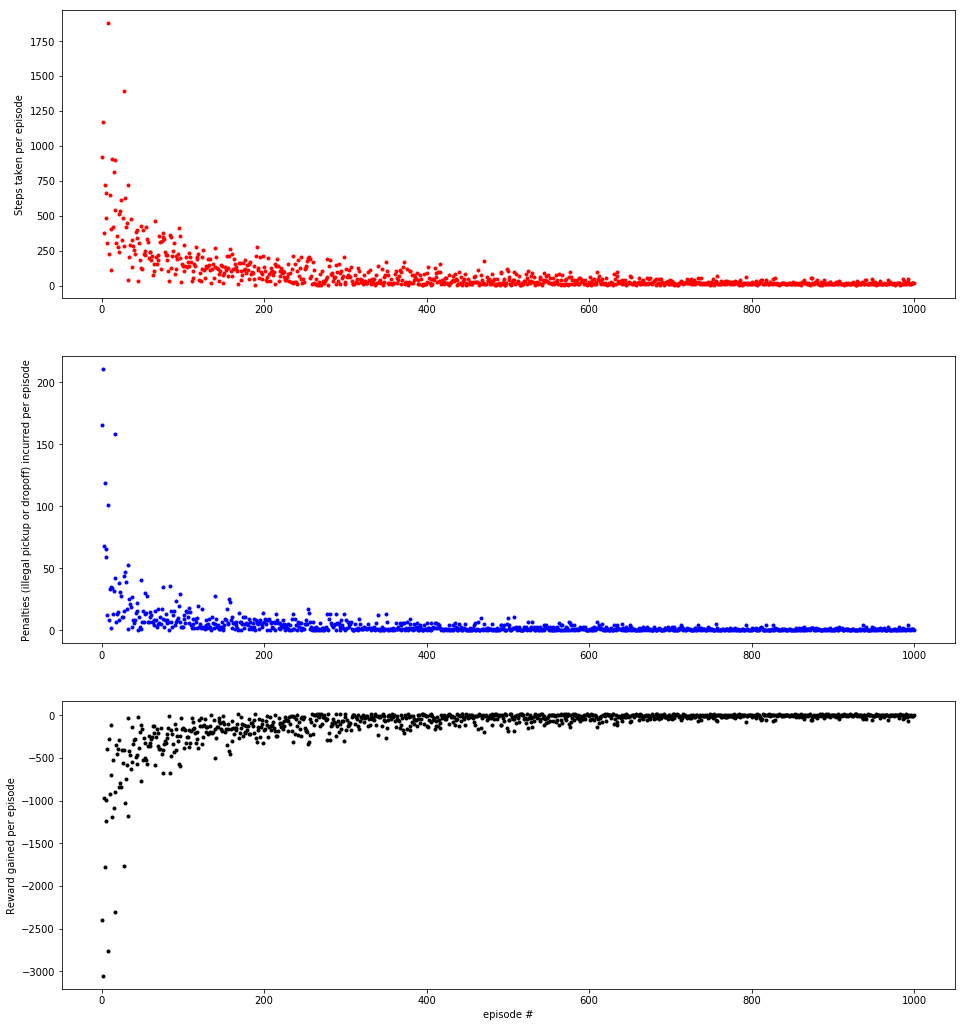

In [9]:
## let's plot the steps, penalties and reward during the training process vs episodes:
fig, ax=plt.subplots(3,1, figsize=(16, 18))
ax[0].plot(np.arange(1, 1001), all_steps[:1000],'r.')
ax[1].plot(np.arange(1, 1001), all_penalties[:1000],'b.')
ax[2].plot(np.arange(1, 1001), all_reward[:1000],'k.')
ax[0].set_ylabel('Steps taken per episode')
ax[1].set_ylabel('Penalties (illegal pickup or dropoff) incurred per episode')
ax[2].set_ylabel('Reward gained per episode')
ax[2].set_xlabel('episode #')

#### We can see that our agent converged after only around 700 episodes

#### Evaluate our Q-learning trained agent versus a random picking agent using steps, penalties and reward averaged over 100 episodes:

In [14]:
## run 100 episodes using our trained Q-learning agents
episodes=100

steps=[]
penalties=[]
reward=[]

for i in range(episodes):
    state=env.reset()
    step, penalty, R=0, 0, 0
    Done=False
    
    while not Done:
        
        action=np.argmax(q_tab[state]) ## picking the best action according to the trained Q-value table.
        
        next_state, r, Done, info=env.step(action)
        
        state=next_state
        
        step+=1
        if r==-10:
            penalty+=1
        R+=r
        
    steps.append(step)
    penalties.append(penalty)
    reward.append(R)
    
print('Q-learning agent, average steps per episode: \t', np.array(steps).mean())
print('Q-learning agent, average penalties per episode:\t', np.array(penalties).mean())
print('Q-learning agent, average rewards per episode:\t', np.array(reward).mean())

Q-learning agent, average steps per episode: 	 12.46
Q-learning agent, average penalties per episode:	 0.0
Q-learning agent, average rewards per episode:	 8.54


In [15]:
## now let's do the same evaluation for a random agent:
episodes=100

steps=[]
penalties=[]
reward=[]

for i in range(episodes):
    state=env.reset()
    step, penalty, R=0, 0, 0
    Done=False
    
    while not Done:
        
        action=env.action_space.sample() ## random picking a action
        
        next_state, r, Done, info=env.step(action)
        
        state=next_state
        
        step+=1
        if r==-10:
            penalty+=1
        R+=r
        
    steps.append(step)
    penalties.append(penalty)
    reward.append(R)
    
print('Random agent, average steps per episode: \t', np.array(steps).mean())
print('Random agent, average penalties per episode: \t', np.array(penalties).mean())
print('Random agent, average rewards per episode: \t', np.array(reward).mean())

Random agent, average steps per episode: 	 2238.7
Random agent, average penalties per episode: 	 723.58
Random agent, average rewards per episode: 	 -8729.92


#### We can see that our Q-learning trained agent performed way better than a random agent, with 0 penalties, average 12.5 steps per trip and average reward of 8.5 per trip.